Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

If you worked locally, and then uploaded your work to the hub, make sure to follow these steps:
- open your uploaded notebook **on the hub**
- hit the validate button right above this cell, from inside the notebook

These  steps should solve any issue related to submitting the notebook on the hub.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = ""

---

# Homework 2: Food Safety 

## Course Policies

Here are some important course policies. These are also located at
http://www.ds100.org/sp18/.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.


## Due Date

This assignment is due at 11:59pm Tuesday, February 6th. Instructions for submission are on the website.

# Homework 2: Food Safety 
## Cleaning and Exploring Data with Pandas

<img src="scoreCard.jpg" width=400>

In this homework, you will investigate restaurant food safety scores for restaurants in San Francisco. Above is a sample score card for a restaurant. The scores and violation information have been made available by the San Francisco Department of Public Health, and we have made these data available to you via the DS 100 repository. The main goal for this assignment is to understand how restaurants are scored. We will walk through the various steps of exploratory data analysis to do this. To give you a sense of how we think about each discovery we make and what next steps it leads to we will provide comments and insights along the way.

As we clean and explore these data, you will gain practice with:
* Reading simple csv files
* Working with data at different levels of granularity
* Identifying the type of data collected, missing values, anomalies, etc.
* Exploring characteristics and distributions of individual variables

### Question 0

To start the assignment, run the cell below to set up some imports and the automatic tests that we will need for this assignment:

In many of these assignments (and your future adventures as a data scientist) you will use os, zipfile, pandas, numpy, matplotlib.pyplot, and seaborn.  

1. Import each of these libraries `as` their commonly used abbreviations (e.g., `pd`, `np`, `plt`, and `sns`).  
1. Don't forget to use the jupyter notebook "magic" to enable [inline matploblib plots](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib). 
1. Add the line `sns.set()` to make your plots look nicer.

In [17]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [18]:
import sys

assert 'zipfile'in sys.modules
assert 'pandas'in sys.modules and pd
assert 'numpy'in sys.modules and np
assert 'matplotlib'in sys.modules and plt
assert 'seaborn'in sys.modules and sns

## Downloading the data

As you saw in lectures, we can download data from the internet with Python.  
Using the `utils.py` file from the lectures (see [link](http://www.ds100.org/sp18/assets/lectures/lec05/utils.py)), define a helper function `fetch_and_cache` to download the data with the following arguments:
- data_url: the web address to download
- file: the file in which to save the results
- data_dir: (default="data") the location to save the data
- force: if true the file is always re-downloaded 

This function should return `pathlib.Path` object representing the file.

In [19]:
import requests
from pathlib import Path

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded 
    
    return: The pathlib.Path object representing the file.
    """
    import requests
    from pathlib import Path
    
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time
        time_downloaded = time.ctime(file_path.stat().st_ctime)
        print("Using version already downloaded:", time_downloaded)
    return file_path

Now use the previously defined function to download the data from the following URL: https://extxfer.sfdph.org/food/SFBusinesses.zip

In [20]:
data_url = 'https://extxfer.sfdph.org/food/SFBusinesses.zip'
file_name = 'data.zip'
data_dir = '.'


dest_path = fetch_and_cache(data_url=data_url, data_dir=data_dir, file=file_name)
print('Saved at {}'.format(dest_path))

Downloading... Done!
Saved at data.zip


## Loading Food Safety Data

To begin our investigation, we need to understand the structure of the data. Recall this involves answering questions such as 

* Is the data in a standard format or encoding?
* Is the data organized in records?
* What are the fields in each record?

There are 4 files in the data directory.  Let's use Python to understand how this data is laid out.

Use the `zipfile` library to list all the files stored in the `dest_path` directory.

Creating a ZipFile object might be a good start (the [Python docs](https://docs.python.org/3/library/zipfile.html) have further details).

In [21]:
# Fill in the list_files variable with a list of all the names of the files in the zip file
my_zip = zipfile.ZipFile(dest_path,"r")
list_names = my_zip.namelist()

In [22]:
assert isinstance(my_zip, zipfile.ZipFile)
assert isinstance(list_names, list)
assert all([isinstance(file, str) for file in list_names]) 


Now display the files' names and their sizes.

You might want to check the attributes of a `ZipFile` object.

In [23]:
my_zip.infolist()

[<ZipInfo filename='violations.csv' compress_type=deflate external_attr=0x20 file_size=3832383 compress_size=294329>,
 <ZipInfo filename='businesses.csv' compress_type=deflate external_attr=0x20 file_size=652363 compress_size=177472>,
 <ZipInfo filename='inspections.csv' compress_type=deflate external_attr=0x20 file_size=465299 compress_size=83819>,
 <ZipInfo filename='legend.csv' compress_type=deflate external_attr=0x20 file_size=120 compress_size=104>]

### Question 1a

From the above output we see that one of the files is relatively small.

Still based on the [HTML notebook](http://www.ds100.org/sp18/assets/lectures/lec03/03-live-datatables-indexes-pandas.html) of Prof. Perez, display the 5 first lines of this file.

In [24]:
file_to_open = "legend.csv"
with my_zip.open(file_to_open) as f:
    for i in range(5):
        print(f.readline().rstrip().decode())

"Minimum_Score","Maximum_Score","Description"
0,70,"Poor"
71,85,"Needs Improvement"
86,90,"Adequate"
91,100,"Good"


In [25]:
assert isinstance(file_to_open, str)


Let us define a function to perform this.

Using the `utils.py` file from the lectures (see [link]()), define a `head` function to display the first lines of the content of a file.

In [26]:
def head(filename, lines=5):
    """
    Returns the first few lines of a file.
    
    filename: the name of the file to open
    lines: the number of lines to include
    
    return: A list of the first few lines from the file.
    """
    ret = []
    with my_zip.open(filename) as file:
        for i in range(lines):
            ret.append(file.readline().rstrip().decode())
    return ret

### Question 1b

Use the `head` function to verify that the remaining files are also CSV formatted as their file extension suggests.

We will extract the content of the zip file to a `data` directory.

In [27]:
data_dir = Path('data')
my_zip.extractall(data_dir)


for i in os.listdir(data_dir):
    print(head(i))

['"business_id","name","address","city","state","postal_code","latitude","longitude","phone_number"', '19,"NRGIZE LIFESTYLE CAFE","1200 VAN NESS AVE, 3RD FLOOR","San Francisco","CA","94109","37.786848","-122.421547","+14157763262"', '24,"OMNI S.F. HOTEL - 2ND FLOOR PANTRY","500 CALIFORNIA ST, 2ND  FLOOR","San Francisco","CA","94104","37.792888","-122.403135","+14156779494"', '31,"NORMAN\'S ICE CREAM AND FREEZES","2801 LEAVENWORTH ST ","San Francisco","CA","94133","37.807155","-122.419004",""', '45,"CHARLIE\'S DELI CAFE","3202 FOLSOM ST ","San Francisco","CA","94110","37.747114","-122.413641","+14156415051"']
['"business_id","score","date","type"', '19,"94","20171211","routine"', '19,"96","20180607","routine"', '19,"94","20160513","routine"', '24,"96","20160311","routine"']
['"business_id","date","description"', '19,"20180607","Inadequate food safety knowledge or lack of certified food safety manager"', '19,"20171211","Unapproved or unmaintained equipment or utensils  [ date violation c

Answer the following boolean expressions using `True` or `False`.

In [28]:
# Are all the files CSV files?
all_files_appear_to_be_csv = True

# Do all the files have a header line?
all_files_contain_headers = True

# Do all the strings in the file have quotes around them?
strings_appear_quoted = True


Do not edit the empty cell below.

### Question 1c

Based on the above information let's attempt to load the `businesses.csv`, `inspections.csv`, and the `violations.csv` into pandas data frames with the following names `bus`, `ins`, and `vio`.

*Note:* Because of character encoding issues one of the files will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. 

In [29]:
# path to directory containing data
dsDir = Path('data')

# Make sure to use these names
bus = pd.read_csv("./data/businesses.csv", encoding='ISO-8859-1')
ins = pd.read_csv("./data/inspections.csv", encoding='ISO-8859-1')
vio = pd.read_csv("./data/violations.csv", encoding='ISO-8859-1')

Now, we perform some sanity checks for you to verify that you loaded the data with the right structure. First, run the following cells to load some basic utilities (you do not need to change these at all):

In [30]:
"""Run this cell to load this utility comparison function that we will use in various
tests below (both tests you can see and those we run internally for grading).

Do not modify the function in any way.
"""

def df_allclose(actual, desired, columns=None, rtol=5e-2):
    """Compare selected columns of two dataframes on a few summary statistics.
    
    Compute the min, median and max of the two dataframes on the given columns, and compare
    that they match numerically to the given relative tolerance.
    
    If they don't match, an AssertionError is raised (by `numpy.testing`).
    """
    import numpy.testing as npt
    
    # summary statistics to compare on
    stats = ['min', '50%', 'max']
    
    # For the desired values, we can provide a full DF with the same structure as
    # the actual data, or pre-computed summary statistics.
    # We assume a pre-computed summary was provided if columns is None. In that case, 
    # `desired` *must* have the same structure as the actual's summary
    if columns is None:
        des = desired
        columns = desired.columns
    else:
        des = desired[columns].describe().loc[stats]

    # Extract summary stats from actual DF
    act = actual[columns].describe().loc[stats]

    npt.assert_allclose(act, des, rtol)

In [31]:
len(bus)

6374

First, we check the basic structure of the data frames you got:

In [32]:
assert all(bus.columns == ['business_id', 'name', 'address', 'city', 'state', 'postal_code',
                           'latitude', 'longitude', 'phone_number'])
assert 6400 <= len(bus) <= 6420

assert all(ins.columns == ['business_id', 'score', 'date', 'type'])
assert 14210 <= len(ins) <= 14250

assert all(vio.columns == ['business_id', 'date', 'description'])
assert 39020 <= len(vio) <= 39080

AssertionError: 

Numerical tests: the following are hand-computed statistical summaries of the correct data. Your own data variables `bus`, `ins` and `vio` should provide similar results with the `describe()` method. Let's look at these once so you can compare. Once you have it all working, you can run the tests in the next cell to verify it numerically.

In [33]:
bus_summary = pd.DataFrame(**{'columns': ['business_id', 'latitude', 'longitude'],
 'data': {'business_id': {'50%': 68294.5, 'max': 94574.0, 'min': 19.0},
  'latitude': {'50%': 37.780435, 'max': 37.824494, 'min': 37.668824},
  'longitude': {'50%': -122.41885450000001,
   'max': -122.368257,
   'min': -122.510896}},
 'index': ['min', '50%', 'max']})

ins_summary = pd.DataFrame(**{'columns': ['business_id', 'score'],
 'data': {'business_id': {'50%': 61462.0, 'max': 94231.0, 'min': 19.0},
  'score': {'50%': 92.0, 'max': 100.0, 'min': 48.0}},
 'index': ['min', '50%', 'max']})

vio_summary = pd.DataFrame(**{'columns': ['business_id'],
 'data': {'business_id': {'50%': 62060.0, 'max': 94231.0, 'min': 19.0}},
 'index': ['min', '50%', 'max']})

from IPython.display import display

print('Businesses:')
display(bus_summary)
print('Inspections:')
display(ins_summary)
print('Violations:')
display(vio_summary)

Businesses:


,business_id,latitude,longitude
min,19.0,37.668824,-122.510896
50%,68294.5,37.780435,-122.418855
max,94574.0,37.824494,-122.368257


Inspections:


,business_id,score
min,19.0,48.0
50%,61462.0,92.0
max,94231.0,100.0


Violations:


,business_id
min,19.0
50%,62060.0
max,94231.0


Numerical tests: the following cell provides summary values that you should be able to match for the three main datasets. We will conduct other tests internally, but you should have loaded your data in a way that matches these few summary statistics.

In [34]:
# These tests will raise an exception if your variables don't match numerically the correct
# answers in the main summary statistics shown above.
df_allclose(bus, bus_summary)
df_allclose(ins, ins_summary)
df_allclose(vio, vio_summary)

AssertionError: 
Not equal to tolerance rtol=0.05, atol=0

(mismatch 16.66666666666667%)
 x: array([[1.9000e+01, 4.5000e+01],
       [6.3651e+04, 9.2000e+01],
       [9.6775e+04, 1.0000e+02]])
 y: array([[1.9000e+01, 4.8000e+01],
       [6.1462e+04, 9.2000e+01],
       [9.4231e+04, 1.0000e+02]])

Do not edit the empty cell below.

Run the following cells in order to view a portion of each dataframe.

In [35]:
bus.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


In [36]:
bus

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440
5,54,RHODA GOLDMAN PLAZA,2180 POST ST,San Francisco,CA,94115,37.784626,-122.437734,+14153455060
6,56,CAFE X + O,1799 CHURCH ST,San Francisco,CA,94131,37.742325,-122.426476,+14158263535
7,58,OASIS GRILL,91 DRUMM ST,San Francisco,CA,94111,37.794483,-122.396584,+14158341942
8,61,CHOWDERS,PIER 39 SPACE A3,San Francisco,CA,94133,37.808240,-122.410189,+14153914737
9,66,STARBUCKS COFFEE,1800 IRVING ST,San Francisco,CA,94122,37.763578,-122.477461,+14152427970


In [37]:
ins.head(5)

,business_id,score,date,type
0,19,94,20171211,routine
1,19,96,20180607,routine
2,19,94,20160513,routine
3,24,96,20160311,routine
4,24,98,20161005,routine


In [38]:
ins

,business_id,score,date,type
0,19,94,20171211,routine
1,19,96,20180607,routine
2,19,94,20160513,routine
3,24,96,20160311,routine
4,24,98,20161005,routine
5,24,98,20171101,routine
6,31,98,20151204,routine
7,31,96,20180615,routine
8,45,78,20160104,routine
9,45,88,20170307,routine


In [39]:
vio.head(5)

,business_id,date,description
0,19,20180607,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensi...
2,19,20171211,Inadequate food safety knowledge or lack of ce...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


In [40]:
vio

,business_id,date,description
0,19,20180607,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensi...
2,19,20171211,Inadequate food safety knowledge or lack of ce...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...
5,19,20160513,Unapproved or unmaintained equipment or utensi...
6,24,20171101,Improper food storage
7,24,20160311,Unclean or degraded floors walls or ceilings ...
8,24,20160311,Unclean or degraded floors walls or ceilings
9,31,20180615,Improper storage of equipment utensils or linens


### Question 1d

In the following describe at least one potential problem with the above data. Consider issues with missing values and bad data.  

In [41]:
q1d_answer = r"""

business_id : name, latitude,longitude,phone_number

"""
print(q1d_answer)



business_id : name, latitude,longitude,phone_number




We will explore each file in turn, including determining its granularity and primary keys and exploring many of the variables indivdually. Let's begin with the businesses file, which has been read into the data.frame `bus`.

## Examining the Business data

From its name alone, we expect the `businesses.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

**Important note: From now on, the local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Question 2

#### Question 2a

Examining the entries in in the `businesses.csv` table `bus` is the `business_id` unique for each record?

`... # use value_counts() or unique() to determine if the business_id field is unique`

In [42]:
is_business_id_unique = bus.business_id.is_unique
is_business_id_unique

True

In [43]:
assert is_business_id_unique

#### Question 2b

With this information, you can address the question of granularity and so answer the questions below.

1. What is the granularity of the businesses data frame? 
1. How many records are there?
1. What does each record represent (e.g., a store, a chain, a transaction)?  
1. What is the primary key?

Please write your answer in the `q2b_answer` variable. You may create new cells to run code as long as you don't delete the cell below.

In [44]:
bus

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440
5,54,RHODA GOLDMAN PLAZA,2180 POST ST,San Francisco,CA,94115,37.784626,-122.437734,+14153455060
6,56,CAFE X + O,1799 CHURCH ST,San Francisco,CA,94131,37.742325,-122.426476,+14158263535
7,58,OASIS GRILL,91 DRUMM ST,San Francisco,CA,94111,37.794483,-122.396584,+14158341942
8,61,CHOWDERS,PIER 39 SPACE A3,San Francisco,CA,94133,37.808240,-122.410189,+14153914737
9,66,STARBUCKS COFFEE,1800 IRVING ST,San Francisco,CA,94122,37.763578,-122.477461,+14152427970


In [45]:
# use this cell for scratch work
# consider using groupby or value_counts() on the 'name' or 'business_id' 
len(bus)
# YOUR CODE HERE


6374

In [46]:
q2b_answer = r"""

1. high
2. 6394
3. a transaction
4. business-id
"""

# YOUR CODE HERE

print(q2b_answer)



1. high
2. 6394
3. a transaction
4. business-id



In [281]:
bus

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440
5,54,RHODA GOLDMAN PLAZA,2180 POST ST,San Francisco,CA,94115,37.784626,-122.437734,+14153455060
6,56,CAFE X + O,1799 CHURCH ST,San Francisco,CA,94131,37.742325,-122.426476,+14158263535
7,58,OASIS GRILL,91 DRUMM ST,San Francisco,CA,94111,37.794483,-122.396584,+14158341942
8,61,CHOWDERS,PIER 39 SPACE A3,San Francisco,CA,94133,37.808240,-122.410189,+14153914737
9,66,STARBUCKS COFFEE,1800 IRVING ST,San Francisco,CA,94122,37.763578,-122.477461,+14152427970


## Zip code

Next, let's  explore some of the variables in the business table. We begin by examining the postal code.

### Question 3

#### Question 3a


What kind of values are in the variable postal code in the `bus` data frame?  
1. Is zip code quantitative or qualitative? If qualitative, is it ordinal or nominal? 
1. How are the zip code values encoded in python: ints, floats, strings, booleans ...

To answer the second question you might want to examine a particular entry.

In [282]:
type(bus['postal_code'][0])

str

In [283]:
# Use this cell for your explorations.
q3a_answer = r"""

qualitative, ordinal
strings

"""


print(q3a_answer)



qualitative, ordinal
strings




#### Question 3b

To explore the zip code values, it makes sense to examine counts, i.e., the number of records  that have the same zip code value. This is essentially answering the question: How many restaurants are in each zip code? 

Please generate a dataframe with the following structure:

- `postal_code` as the index
- A column called `count` which denotes the number of restaurants for each zip code.
- If the zipcode is missing be sure to replace it with the string `MISSING` (e.g., by using `fillna`).

In [47]:
zip_counts = bus.postal_code.fillna("MISSING").value_counts()
zip_counts = pd.DataFrame(zip_counts)
zip_counts.columns = ["count"]
zip_counts

,count
94110,593
94103,563
94102,462
94133,425
94107,399
94109,383
94111,280
94122,268
94118,245
94115,244


In [48]:
assert isinstance(zip_counts, pd.DataFrame)
assert zip_counts.columns == ['count']
assert 'MISSING' in list(zip_counts.index)


We see that there are many missing values for zip code. There is also some bad data where the postal code got screwed up, e.g., there are 3 'Ca' and 3 'CA' values. Additionally, there are some extended postal codes that are 9 digits long, rather than the typical 5 digits.

Let's clean up the extended zip codes by dropping the digits beyond the first 5. It's typically good practice to keep the original values when we are manipulating data and place the modified data in a new column in the DataFrame. We'll call the new column `zip_code`.

In [50]:
# Run me
bus['zip_code'] = bus['postal_code'].str[:5]
bus['zip_code'].value_counts(dropna=False)

94110    594
94103    564
94102    462
94133    425
94107    399
94109    383
94111    280
94122    268
94118    245
94115    244
94105    242
NaN      230
94108    225
94114    208
94117    207
94124    204
94112    192
94123    181
94121    160
94104    146
94132    136
94116    100
94134     79
94127     69
94131     49
94158     32
94130      8
94143      5
94188      4
94014      3
00000      2
CA         2
94301      2
94101      2
94013      2
94901      1
94621      1
94712      1
Ca         1
94080      1
94129      1
95109      1
95117      1
64110      1
94066      1
94602      1
94402      1
95105      1
95122      1
94120      1
95132      1
92672      1
94544      1
941        1
94545      1
Name: zip_code, dtype: int64

In [51]:
s = bus[bus.postal_code.isnull()]
s

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code
1559,8202,XIAO LOONG,250 WEST PORTAL AVENUE,San Francisco,CA,NaN,37.738616,-122.468775,+14152792647,NaN
1582,9358,EDGEWOOD CHILDREN'S CENTER,1801 VICENTE ST,San Francisco,CA,NaN,37.739083,-122.485437,NaN,NaN
1587,9582,DIMPLES,1700 POST ST.,San Francisco,CA,NaN,37.785632,-122.429794,+14155190341,NaN
1607,10227,THE NAPPER TANDY,3200 24TH ST,San Francisco,CA,NaN,37.752581,-122.416482,+14155507510,NaN
1615,10372,BERNAL HEIGHTS NEIGBORHOOD CENTER,515 CORTLAND AVE,San Francisco,CA,NaN,37.739110,-122.416404,+14152062142,NaN
1616,10373,EL TONAYENSE #1,1717 HARRISON ST,San Francisco,CA,NaN,37.769426,-122.413446,+14155596127,NaN
1617,10376,GOOD FRIKIN CHICKEN,10 29TH ST,San Francisco,CA,NaN,37.744369,-122.420967,+14158601365,NaN
1619,10406,SUNSET YOUTH SERVICES,3918 JUDAH ST,San Francisco,CA,NaN,37.760560,-122.504027,NaN,NaN
1631,10964,ANGEL'S HOT DOGS,CORNER OF ALAMEDA AND HENRY ADAMS,San Francisco,CA,NaN,NaN,NaN,NaN,NaN
1640,11416,EL BEACH BURRITO,3914 JUDAH ST,San Francisco,CA,NaN,37.760851,-122.503998,NaN,NaN


#### Question 3c

We notice that there are still a lot of missing values!  Examine the businesses with missing zipcode values.  Pay attention to their addresses.  Are there any patterns to missing values in zip codes?

**Hint:** You can use `.iloc` to look at different sections of the DataFrame.

In [289]:
# Use this cell for your explorations.
q3c_answer = r"""

The address is rough.
"""

print(q3c_answer)



The address is rough.



#### Question 3d

Often times, we need to get additional information in order to understand whether or not the data are bad values or simply unusual values. With zip codes, we can use the Internet to investigate the zip codes that have only a few businesses. Investigate the restaurants at the following zip codes: *94545*, *94602*, and *94609*.  

Briefly describe why these strange zip codes might be appropriate.  Where are they located and how might they relate to San Francisco?


In [290]:
bus

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122
5,54,RHODA GOLDMAN PLAZA,2180 POST ST,San Francisco,CA,94115,37.784626,-122.437734,+14153455060,94115
6,56,CAFE X + O,1799 CHURCH ST,San Francisco,CA,94131,37.742325,-122.426476,+14158263535,94131
7,58,OASIS GRILL,91 DRUMM ST,San Francisco,CA,94111,37.794483,-122.396584,+14158341942,94111
8,61,CHOWDERS,PIER 39 SPACE A3,San Francisco,CA,94133,37.808240,-122.410189,+14153914737,94133
9,66,STARBUCKS COFFEE,1800 IRVING ST,San Francisco,CA,94122,37.763578,-122.477461,+14152427970,94122


In [303]:
s = bus[bus.postal_code == "94609"]
s

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code


In [292]:
# Use this cell for your explorations.
q3d_answer = r"""

Put your answer here, replacing this text.  Do not take into account the ### YOUR CODE HERE below

94545 - 5755	J & J VENDING	VARIOUS LOACATIONS (17)	San Francisco	CA	94545	NaN	NaN	+14156750910

94602 - 85459	ORBIT ROOM	1900 MARKET ST	San Francisco	CA	94602	NaN	NaN	+14153705584

94609 - ...

"""


print(q3d_answer)



Put your answer here, replacing this text.  Do not take into account the ### YOUR CODE HERE below

94545 - 5755	J & J VENDING	VARIOUS LOACATIONS (17)	San Francisco	CA	94545	NaN	NaN	+14156750910

94602 - 85459	ORBIT ROOM	1900 MARKET ST	San Francisco	CA	94602	NaN	NaN	+14153705584

94609 - ...




#### Question 3e

Often want to clean the data to improve our analysis. This cleaning might include changing values for a variable or dropping records.

Let's correct 94602 to the more likely value based on your analysis.  Let's modify the derived field `zip_code` using `bus['zip_code'].str.replace` to replace 94602 with the correct value.

In [52]:
bus['zip_code'].str.replace("94602", "94102")

0       94109
1       94104
2       94133
3       94110
4       94122
5       94115
6       94131
7       94111
8       94133
9       94122
10      94110
11      94115
12      94104
13      94104
14      94117
15      94117
16      94107
17      94110
18      94133
19      94108
20      94108
21      94102
22      94108
23      94111
24      94108
25      94133
26      94102
27      94104
28      94115
29      94103
        ...  
6344    94102
6345    94123
6346    94118
6347    94102
6348    94118
6349    94132
6350    94109
6351    94112
6352    94124
6353    94116
6354    94102
6355    94103
6356    94127
6357    94108
6358    94132
6359      NaN
6360    94132
6361    94110
6362    94103
6363    94115
6364    94102
6365    94115
6366    94122
6367    94131
6368    94118
6369    94104
6370    94109
6371    94103
6372      NaN
6373    94116
Name: zip_code, Length: 6374, dtype: object

In [53]:
assert "94602" not in bus['zip_code']

## Latitude and Longitude

Another aspect of the data we want to consider is the prevalence of missing values. If many records have missing values then we might be concerned about whether the nonmissing values are represenative of the population.

### Question 4
 
Consider the longitude and latitude in the business DataFrame. 

#### Question 4a

How many businesses are missing longitude and latitude values?

In [310]:
missing_latlongs = len(bus[bus.longitude.isnull() | bus.latitude.isnull()])


3293

In [309]:
assert missing_latlongs == sum(bus['longitude'].isnull())

Do some zip codes have more than their fair share of missing lat/lon values?

Let's reduce our comparison to just those zips that are in SF and that have many businesses. Below is a list of zip codes.

In [311]:
validZip = ["94102", "94103", "94104", "94105", "94107", "94108",
            "94109", "94110", "94111", "94112", "94114", "94115",
            "94116", "94117", "94118", "94121", "94122", "94123", 
            "94124", "94127", "94131", "94132", "94133", "94134"]

In [398]:
y = pd.DataFrame(bus["zip_code"])
y = pd.DataFrame(y.zip_code.value_counts())
y.columns = ["count"]
y = y["count"]
y

94110    595
94103    564
94102    462
94133    423
94107    399
94109    383
94111    280
94122    268
94118    245
94115    244
94105    242
94108    225
94114    208
94117    207
94124    204
94112    192
94123    181
94121    160
94104    146
94132    136
94116    100
94134     79
94127     69
94131     49
94158     32
94130      8
94143      5
94188      4
94014      3
94301      2
94013      2
94101      2
00000      2
CA         2
64110      1
94545      1
95132      1
94712      1
94402      1
95117      1
94129      1
95122      1
94120      1
941        1
94080      1
94621      1
94544      1
94066      1
95105      1
92672      1
95109      1
94602      1
Ca         1
94901      1
Name: count, dtype: int64

In [396]:
def set_1_or_0(x):
    return x != 0
x = bus[["latitude", "longitude", "zip_code"]]
x = x.fillna(0)
x["NaN"] = (x.latitude.apply(set_1_or_0)) & (x.longitude.apply(set_1_or_0))
x = x.drop(["latitude", "longitude"], axis = 1)
x = x.groupby("zip_code").sum()
x.columns = ["count"]
x = pd.Series(x["count"])
x

zip_code
0         52.0
00000      1.0
64110      0.0
92672      1.0
94013      2.0
94014      0.0
94066      0.0
94080      0.0
941        1.0
94101      1.0
94102    230.0
94103    258.0
94104     60.0
94105    102.0
94107    132.0
94108    121.0
94109    197.0
94110    283.0
94111    144.0
94112    116.0
94114    102.0
94115    142.0
94116     56.0
94117    114.0
94118    127.0
94120      1.0
94121     96.0
94122    137.0
94123    102.0
94124     71.0
94127     38.0
94129      0.0
94130      2.0
94131     31.0
94132     59.0
94133    255.0
94134     39.0
94143      2.0
94158      2.0
94188      0.0
94301      0.0
94402      0.0
94544      0.0
94545      0.0
94602      0.0
94621      0.0
94712      0.0
94901      0.0
95105      1.0
95109      0.0
95117      0.0
95122      0.0
95132      0.0
CA         2.0
Ca         0.0
Name: count, dtype: float64

In [400]:
z = y - x
z = z.dropna()
z

/home/sean/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7435: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return_indexers=True)


94110    312.0
94103    306.0
94102    232.0
94133    168.0
94107    267.0
94109    186.0
94111    136.0
94122    131.0
94118    118.0
94115    102.0
94105    140.0
94108    104.0
94114    106.0
94117     93.0
94124    133.0
94112     76.0
94123     79.0
94121     64.0
94104     86.0
94132     77.0
94116     44.0
94134     40.0
94127     31.0
94131     18.0
94158     30.0
94130      6.0
94143      3.0
94188      4.0
94014      3.0
94301      2.0
94013      0.0
94101      1.0
00000      1.0
CA         0.0
64110      1.0
94545      1.0
95132      1.0
94712      1.0
94402      1.0
95117      1.0
94129      1.0
95122      1.0
94120      0.0
941        0.0
94080      1.0
94621      1.0
94544      1.0
94066      1.0
95105      0.0
92672      0.0
95109      1.0
94602      1.0
Ca         1.0
94901      1.0
Name: count, dtype: float64

#### Question 4b

For these zip codes find the number of businesses in each zip code and the number without longitude values. Do any zip codes appear to have more than their 'fair share' of missing longitude? To answer this, you will want to compare the proportion of missing values for each zip code.

Create a new dataframe of counts of the null and proportion of null values, storing the result in `bus_sf_latlong`. It should have 3 columns:

1. `zip_code`: Contains the zip codes in the `validZip` variable above.
2. `null_lon`: The number of missing values for the zip code.
3. `not_null_lon`: The proportion of present values for the zip code.

In [442]:
# You might want to filter the bus dataframe to contain only the validZip
bus_sf = bus[bus["zip_code"].isin(validZip)]
y = pd.DataFrame(z)
bus_sf[""]
#bus_sf_latlong = pd.DataFrame(bus_sf, columns = ["zip_code", "null_lon", "not_null_lon"])


,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122
5,54,RHODA GOLDMAN PLAZA,2180 POST ST,San Francisco,CA,94115,37.784626,-122.437734,+14153455060,94115
6,56,CAFE X + O,1799 CHURCH ST,San Francisco,CA,94131,37.742325,-122.426476,+14158263535,94131
7,58,OASIS GRILL,91 DRUMM ST,San Francisco,CA,94111,37.794483,-122.396584,+14158341942,94111
8,61,CHOWDERS,PIER 39 SPACE A3,San Francisco,CA,94133,37.808240,-122.410189,+14153914737,94133
9,66,STARBUCKS COFFEE,1800 IRVING ST,San Francisco,CA,94122,37.763578,-122.477461,+14152427970,94122


Do not edit the empty cell below.

## Summary of the business data

Before we move on to explore the other data, let's take stock of what we have learned and the implications of our findings on future analysis. 

* We found that the business id is unique across records and so we may be able to use it as a key in joining tables. 
* We also found that there are some bad values in zip code. As a result, we may want to drop the records with zip codes outside of San Francisco or to treat them differently. For some of the bad values, we may want to take the time to look up the restaurant address online and fix these errors.   
* We also found that there are many missing values in latitude and longitude. These may have implications on map making and geographic patterns if the missingness is related to location or restaurant score.

# Investigate the inspection data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns, these are named `business_id`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections. 

### Question 5

#### Question 5a
As with the business data, assess whether there is one inspection record for each business. 

In [54]:
ins

,business_id,score,date,type
0,19,94,20171211,routine
1,19,96,20180607,routine
2,19,94,20160513,routine
3,24,96,20160311,routine
4,24,98,20161005,routine
5,24,98,20171101,routine
6,31,98,20151204,routine
7,31,96,20180615,routine
8,45,78,20160104,routine
9,45,88,20170307,routine


In [78]:
# The number of rows in ins
rows_in_table = ins.shape[0]

# The number of unique IDs in ins.
unique_ins_ids = len(ins['business_id'].unique())
rows_in_table


14197

In [70]:
assert rows_in_table  == ins.shape[0]
assert unique_ins_ids == len(ins['business_id'].unique())

#### Question 5b

Next, we examine the `type` variable. From examining the first few rows of `ins`, we see that `type` is a string and one of the values in the string is 'routine', presumably for a routine inspection. What values does `type` take on? How many occurrences of each value is in the DataFrame? What are the implications for further analysis?

In [77]:
ins.groupby("type").describe()

business_id                                                         \
                count          mean           std      min      25%      50%   
type                                                                           
complaint         1.0  87440.000000           NaN  87440.0  87440.0  87440.0   
routine       14196.0  47897.804663  35190.073134     19.0   5839.0  63651.0   

                                date                ...                \
               75%      max    count          mean  ...           75%   
type                                                ...                 
complaint  87440.0  87440.0      1.0  2.016080e+07  ...    20160801.0   
routine    80479.0  96775.0  14196.0  2.016787e+07  ...    20171212.0   

                         score                                             \
                  max    count        mean       std    min    25%    50%   
type                                                                        
complaint  20160801.0      1.0  100.000000       NaN  100.0  100.0  100.0   
routine    20180719.0  14196.0   90.463229  7.886004   45.0   86.0   92.0   

                         
             75%    max  
type                     
complaint  100.0  100.0  
routine     96.0  100.0  

[2 rows x 24 columns]

In [79]:
q5b_answer = r"""

complaint 1.0
routine 14196

"""
print(q5b_answer)



complaint 1.0
routine 14196




In [80]:
ins

,business_id,score,date,type
0,19,94,20171211,routine
1,19,96,20180607,routine
2,19,94,20160513,routine
3,24,96,20160311,routine
4,24,98,20161005,routine
5,24,98,20171101,routine
6,31,98,20151204,routine
7,31,96,20180615,routine
8,45,78,20160104,routine
9,45,88,20170307,routine


#### Question 5c

Since the data was stored in a .csv file, the dates are formatted as strings such as `20160503`. Once we read in the data, we would like to have dates in an appropriate format for analsysis. Add a new column called `new_date` which formats the `date` into a datetime object. Then add a column called `year` with only the year.

*Hint: You'll want to use the `pd.datetime` functionality at some point.*

In [113]:
ins['new_date'] = ins['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d'))
ins['year'] = ins['new_date'].apply(lambda d: d.year)
ins

,business_id,score,date,type,new_date,year
0,19,94,20171211,routine,2017-12-11,2017
1,19,96,20180607,routine,2018-06-07,2018
2,19,94,20160513,routine,2016-05-13,2016
3,24,96,20160311,routine,2016-03-11,2016
4,24,98,20161005,routine,2016-10-05,2016
5,24,98,20171101,routine,2017-11-01,2017
6,31,98,20151204,routine,2015-12-04,2015
7,31,96,20180615,routine,2018-06-15,2018
8,45,78,20160104,routine,2016-01-04,2016
9,45,88,20170307,routine,2017-03-07,2017


In [112]:
assert ins['new_date'].equals(ins['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d')))
assert ins['year'].equals(ins['new_date'].apply(lambda d: d.year))

#### Question 5d

What range of years is covered in this data set? Are there roughly same number of inspections each year?

In [117]:
ins.groupby("year").describe()

business_id                                                      \
           count          mean           std   min      25%      50%   
year                                                                   
2015      1200.0  41636.619167  33481.527106  31.0  5791.75  39968.5   
2016      4887.0  44111.000205  33969.084755  19.0  5526.00  60354.0   
2017      4782.0  49313.495399  35470.677444  19.0  5864.25  65057.0   
2018      3328.0  53693.851863  36134.043736  19.0  6483.00  68259.5   

                           date                ...                            \
           75%      max   count          mean  ...           75%         max   
year                                           ...                             
2015  74290.25  86344.0  1200.0  2.015097e+07  ...    20151104.0  20151230.0   
2016  76902.00  90269.0  4887.0  2.016069e+07  ...    20160927.0  20161230.0   
2017  82004.25  94231.0  4782.0  2.017073e+07  ...    20171023.0  20171229.0   
2018  85937.25  96775.0  3328.0  2.018039e+07  ...    20180523.0  20180719.0   

       score                                                      
       count       mean       std   min   25%   50%   75%    max  
year                                                              
2015  1200.0  91.335833  8.144630  55.0  87.0  93.0  98.0  100.0  
2016  4887.0  90.022509  8.167750  48.0  86.0  92.0  96.0  100.0  
2017  4782.0  90.193643  7.919865  53.0  86.0  92.0  96.0  100.0  
2018  3328.0  91.185998  7.222262  45.0  87.0  92.0  96.0  100.0  

[4 rows x 24 columns]

In [118]:
q5d_answer = r"""

2015-2016
No
"""
print(q5d_answer)



2015-2016
No



Let's examine only the inspections for one year, 2016. This puts businesses on a more equal footing because [inspection guidelines](https://www.sfdph.org/dph/eh/Food/Inspections.asp) generally refer to how many inspections should occur in a given year.

In [119]:
ins2016 = ins[ins['year'] == 2016]

In [120]:
ins2016

,business_id,score,date,type,new_date,year
2,19,94,20160513,routine,2016-05-13,2016
3,24,96,20160311,routine,2016-03-11,2016
4,24,98,20161005,routine,2016-10-05,2016
8,45,78,20160104,routine,2016-01-04,2016
10,45,84,20160614,routine,2016-06-14,2016
13,48,94,20160630,routine,2016-06-30,2016
17,56,90,20160802,routine,2016-08-02,2016
22,58,73,20160407,routine,2016-04-07,2016
24,61,94,20160708,routine,2016-07-08,2016
29,66,100,20160902,routine,2016-09-02,2016


## Explore inspection score

### Question 6

#### Question 6a
What does the distribution of inspection score for 2016 look like? The inspection scores appear to be integer values. The discreteness of this variable means that we can use a barplot to visualize the distribution of the inspection score. Find the counts of the number of inspections in 2016 for each score. Then, make a bar plot of these counts.

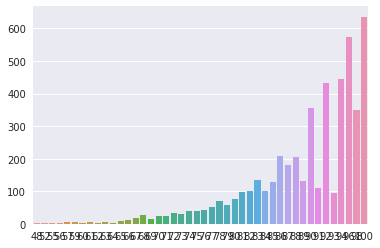

In [127]:
scores = ins2016["score"].value_counts()
scoreCts = sns.barplot(scores.index, scores.values)
plt.show()

#### Question 6b

Describe the qualities of the distribution of the inspections scores. Consider the mode(s), symmetry, tails, gaps, and anamolous values. Are there any unusual features of this distribution? What do your observation imply about the scores?

In [ ]:
q6b_answer = r"""

Put your answer here, replacing this text. Do not take into account the ### YOUR CODE HERE below

"""

# YOUR CODE HERE
raise NotImplementedError()

print(q6b_answer)

#### Question 6c

In assessing the granularity, we want to determine if there is one inspection per business per year. How many restaurants had two inspections? Three or more inspections? Create a dict mapping the number of inspections to the number of business ids with that many inspections.

*Hint: pandas Series have a to_dict() method.*

In [144]:
numIns2numIDs = ins2016["business_id"].value_counts().to_dict()
numIns2numIDs

{4449: 3,
 79346: 3,
 79366: 3,
 79858: 3,
 86336: 3,
 65795: 3,
 76223: 3,
 76441: 3,
 8882: 3,
 69253: 3,
 10377: 3,
 38929: 3,
 5634: 3,
 75055: 3,
 5902: 3,
 7772: 3,
 78985: 3,
 1337: 3,
 74760: 3,
 78368: 3,
 2749: 3,
 69884: 3,
 60210: 3,
 63576: 3,
 69350: 3,
 79525: 3,
 87699: 3,
 2420: 3,
 76233: 3,
 81588: 3,
 38423: 3,
 75465: 3,
 2292: 3,
 5524: 3,
 59727: 3,
 489: 3,
 59397: 3,
 86301: 3,
 2610: 2,
 79565: 2,
 74283: 2,
 69501: 2,
 2836: 2,
 551: 2,
 7689: 2,
 70064: 2,
 13426: 2,
 87761: 2,
 68860: 2,
 1144: 2,
 80280: 2,
 539: 2,
 7275: 2,
 70778: 2,
 6010: 2,
 27055: 2,
 33198: 2,
 78220: 2,
 1912: 2,
 82373: 2,
 70547: 2,
 80299: 2,
 62746: 2,
 2578: 2,
 4944: 2,
 4665: 2,
 4952: 2,
 75258: 2,
 69115: 2,
 3161: 2,
 6756: 2,
 2343: 2,
 7745: 2,
 77564: 2,
 80236: 2,
 36685: 2,
 66656: 2,
 72164: 2,
 298: 2,
 82664: 2,
 2932: 2,
 5966: 2,
 28976: 2,
 2638: 2,
 4685: 2,
 64076: 2,
 70758: 2,
 2418: 2,
 4681: 2,
 71997: 2,
 85185: 2,
 76294: 2,
 4959: 2,
 18767: 2,
 78289

Do not edit the empty cell below.

### Restaurants with multiple inspections

### Question 7

Some restaurants had 3 inspections in a calandar year, but not very many did. To examine the distribution of score among restaurants with two scores, we can look at the change in score from the first inspection.

#### Question 7a

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve?

First, make a dataframe called, `scores_pairs_by_business`, indexed by business_id (containing only business with exactly 2 inspections in 2016).  This dataframe contains the field `score_pair` consisting of the score pairs ordered chronologically  `[first_score, second_score]`. 

Plot these scores. That is, make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1. 

You may find the functions `sort_values`, `groupby`, `filter` and `agg` helpful, though not all necessary. 

The first few rows resulting table should look something like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>score_pair</th>
    </tr>
    <tr>
      <th>business_id</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>24</th>
      <td>[96, 98]</td>
    </tr>
    <tr>
      <th>45</th>
      <td>[78, 84]</td>
    </tr>
    <tr>
      <th>66</th>
      <td>[98, 100]</td>
    </tr>
    <tr>
      <th>67</th>
      <td>[87, 94]</td>
    </tr>
    <tr>
      <th>76</th>
      <td>[100, 98]</td>
    </tr>
  </tbody>
</table>

In [232]:
numIns2numIDs_np = pd.Series(numIns2numIDs, index = numIns2numIDs.keys())
bus_id = pd.Series(numIns2numIDs_np[numIns2numIDs_np == 2].index)

In [248]:
def convert(x):
    return group_to_list(ins2016[ins2016["business_id"] == x]["score"].values)
# For some odd reason, we can't just pass `list` into `.agg` so we define this function:
# You may or may not use it
def group_to_list(group):
    return list(group)
result = bus_id.apply(convert)
x = pd.DataFrame(result)
y = pd.DataFrame(bus_id)
z = pd.concat([y, x], axis = 1)
z.columns = ["business_id", "score_pair"]
scores_pairs_by_business = z.set_index("business_id").sort_index()

Plot these scores. That is, make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1.

You may find the functions sort_values, groupby, filter and agg helpful, though not all necessary.

The first few rows resulting table should look something like:

In [249]:
assert isinstance(scores_pairs_by_business, pd.DataFrame)
assert scores_pairs_by_business.columns == ['score_pair']


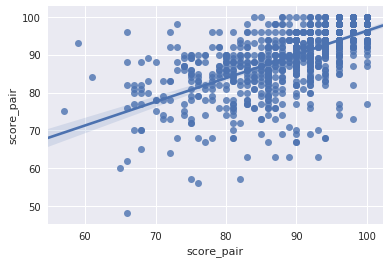

In [250]:
x = scores_pairs_by_business['score_pair'].str[0]
y =  scores_pairs_by_business['score_pair'].str[1]
sns.regplot(x,y)

#### Question 7b

Another way to compare the scores from the two inspections is to examine the difference in scores. Subtract the first score from the second in `scores_pairs_by_business`. Make a histogram of these differences in the scores. We might expect these differences to be positive, indicating an improvement from the first to the second inspection.

(array([  2.,   4.,  19.,  70., 201., 516., 125.,  27.,  17.,   7.]),
 array([-34. , -27.6, -21.2, -14.8,  -8.4,  -2. ,   4.4,  10.8,  17.2,
         23.6,  30. ]),
 <a list of 10 Patch objects>)

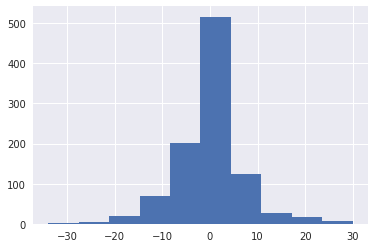

In [270]:
z1 = [i[0] for i in scores_pairs_by_business["score_pair"]]
z2 = [i[1] for i in scores_pairs_by_business["score_pair"]]
z = np.array(z1) - np.array(z2)
plt.hist(z)

#### Question 7c

If a restaurant's score improves from the first to the second inspection, what do you expect to see in the scatter plot that you made in 7a? What do you see?

If a restaurant's score improves from the first to the second inspection, how would this be reflected in the histogram of the difference in the scores that you made in 7b? What do you see?

In [ ]:
q7c_answer = r"""

Put your answer here, replacing this text. Do not take into account the ###YOUR CODE HERE below.

"""

# YOUR CODE HERE
raise NotImplementedError()

print(q7c_answer)

## Summary of the inspections data

What we have learned about the inspections data? What might be some next steps in our investigation? 

* We found that the records are at the inspection level and that we have inspections for multiple years.   
* We also found that may restaurants have more than one inspection a year. In the future, we may want to roll some of the information about the inspections up to the business/restaurant level and join the inspection information with the business dataframe. For example, we could make maps of inspection scores for restaurants.
* We also examined the relationship between the scores when a restaurant has multiple inspections in a year. Our findings were a bit counterintuitive and we warrant further investigation. It also makes sense to learn more about the inspection process to help us understand the connections between scores from multiple inspections. 


## Congrats !

Congrats! You are finished with HW2.